# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Functions 

In [2]:
def null_percentage(df):
    
    nulls = df.isna().mean() * 100   # میانگین True/False ستون × 100 = درصد
    return nulls.sort_values(ascending=False)  # مرتب بر اساس بیشترین نال

In [3]:
def normalize_floor(x):
    if pd.isna(x):     
        return x
    x = str(x).strip()   
    if x.replace('-', '', 1).replace('.', '', 1).isdigit():
        if '.' in x:
            return str(int(float(x)))   
        else:
            return x
    return x 

In [4]:
def convert_floor(x):
    if x == 'Not Given':
        return np.nan
    if x.endswith('+'):
        return int(x[:-1])
    return int(x)

In [5]:
def persian_year_to_int(x):
    if pd.isna(x):
        return np.nan
    if 'قبل از' in x:
        return 1369  # عدد دلخواه برای before 1370
    # تبدیل اعداد فارسی به انگلیسی
    x = x.translate(str.maketrans('۰۱۲۳۴۵۶۷۸۹', '0123456789'))
    return int(x)

# General 

In [6]:
df =pd.read_csv('Divar.csv' , low_memory=False)

In [7]:
df1 = df.copy()

## Location 

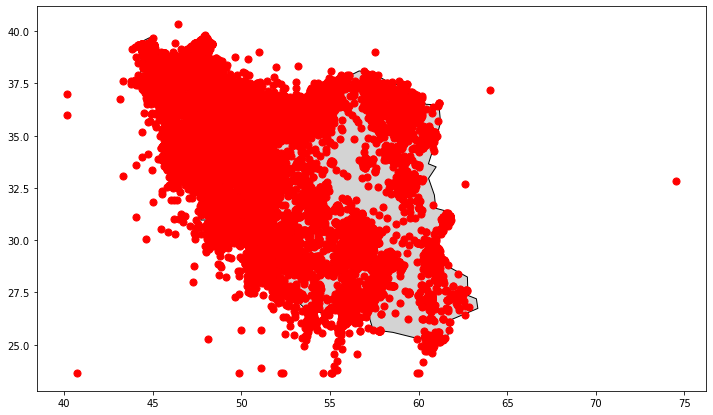

In [5]:
path = r"C:\Users\ASUS\OneDrive\Desktop\New folder (2)\ne_110m_admin_0_countries.shp"
world = gpd.read_file(path)

iran = world[world['NAME'] == 'Iran']   # sometimes column is NAME or name

geometry = [Point(xy) for xy in zip(df1["location_longitude"], df1["location_latitude"])]
gdf = gpd.GeoDataFrame(df1, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")
gdf.plot(ax=ax, color="red", markersize=50)
plt.show()

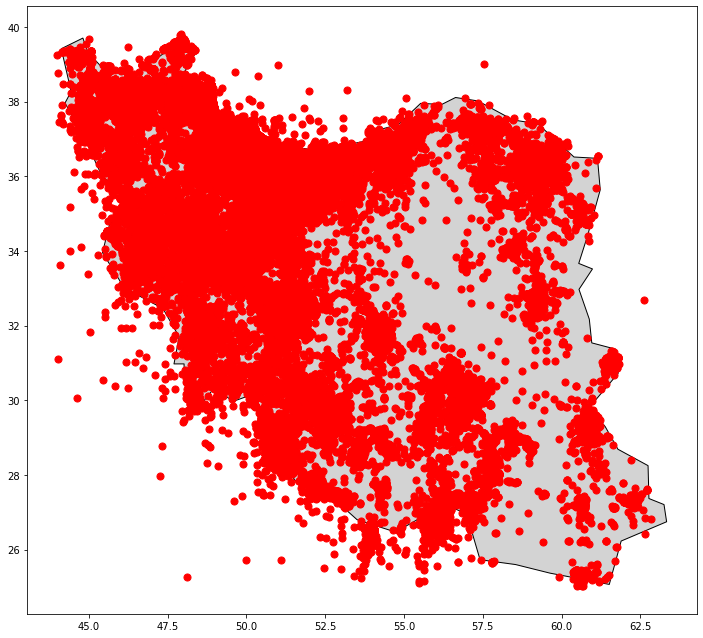

In [7]:
df_clean = df1[(df1['location_longitude']>44 )&(df1['location_longitude']<64 )&(df1['location_latitude']>25)&(df1['location_latitude']<40)]

path = r"C:\Users\ASUS\OneDrive\Desktop\New folder (2)\ne_110m_admin_0_countries.shp"
world = gpd.read_file(path)

iran = world[world['NAME'] == 'Iran']   # sometimes column is NAME or name

geometry = [Point(xy) for xy in zip(df_clean["location_longitude"], df_clean["location_latitude"])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")
gdf.plot(ax=ax, color="red", markersize=50)
plt.show()

### Handeling Location outliers

In [8]:
world = gpd.read_file("ne_110m_admin_0_countries.shp")
iran = world[world['ADMIN'] == 'Iran']

gdf_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['location_longitude'], df['location_latitude']),
    crs="EPSG:4326"
)

gdf_points['in_iran'] = gdf_points.within(iran.geometry.iloc[0])

df_clean = gdf_points[gdf_points['in_iran']]

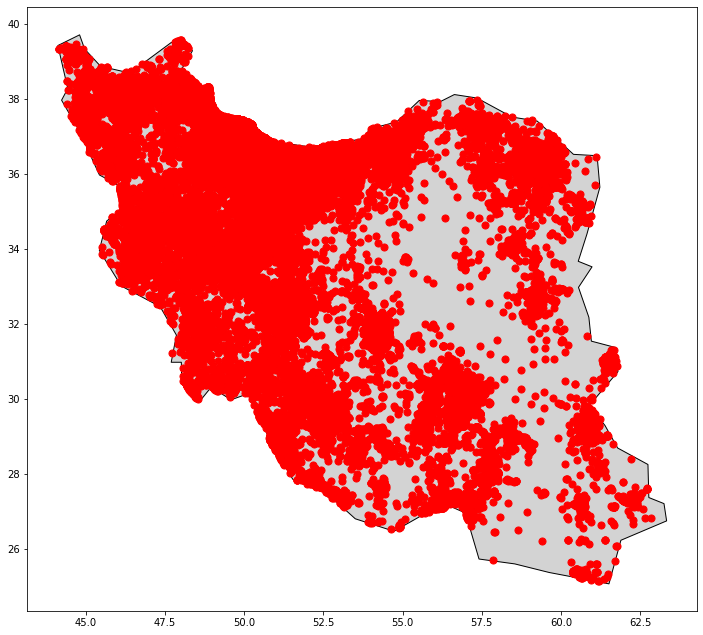

In [9]:
geometry = [Point(xy) for xy in zip(df_clean["location_longitude"], df_clean["location_latitude"])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")
gdf.plot(ax=ax, color="red", markersize=50)
plt.show()

In [9]:
mask = (gdf_points['location_latitude'].isna()) & (gdf_points['location_longitude'].isna())
gdf_points.loc[mask, 'in_iran'] = True
df_in_iran =gdf_points[(gdf_points['in_iran'] == True)]

###  Filling Nan of Location

In [10]:
cities = df_in_iran.city_slug.unique()
good_cities = []
for city in cities:
    neighbor_count = df_in_iran[df_in_iran['city_slug'] == city].neighborhood_slug.isnull().sum()
    if neighbor_count == 0:
        good_cities.append(city)

In [11]:
df_in_iran.loc[df_in_iran['city_slug'].isin(good_cities), 'location_latitude'] = (
    df_in_iran[df_in_iran['city_slug'].isin(good_cities)]
    .groupby(['city_slug', 'neighborhood_slug'])['location_latitude']
    .transform(lambda x: x.fillna(x.mean()))
)

df_in_iran.loc[df_in_iran['city_slug'].isin(good_cities), 'location_longitude'] = (
    df_in_iran[df_in_iran['city_slug'].isin(good_cities)]
    .groupby(['city_slug', 'neighborhood_slug'])['location_longitude']
    .transform(lambda x: x.fillna(x.mean()))
)

df_in_iran.loc[~df_in_iran['city_slug'].isin(good_cities), 'location_latitude'] = (
    df_in_iran[~df_in_iran['city_slug'].isin(good_cities)]
    .groupby('city_slug')['location_latitude']
    .transform(lambda x: x.fillna(x.mean()))
)

df_in_iran.loc[~df_in_iran['city_slug'].isin(good_cities), 'location_longitude'] = (
    df_in_iran[~df_in_iran['city_slug'].isin(good_cities)]
    .groupby('city_slug')['location_longitude']
    .transform(lambda x: x.fillna(x.mean()))
)

In [12]:
df_in_iran[df_in_iran.location_longitude.isna()].city_slug.unique()

array(['dargahan', 'tehran', nan, 'isfahan'], dtype=object)

In [13]:
df_in_iran.loc[df_in_iran['city_slug']== 'dargahan' , 'location_longitude'] = df_in_iran[df_in_iran['city_slug'] == 'dargahan']['location_longitude'].fillna(56.0608)
df_in_iran.loc[df_in_iran['city_slug']== 'dargahan' , 'location_latitude' ] = df_in_iran[df_in_iran['city_slug'] == 'dargahan']['location_latitude' ].fillna(26.963)

In [14]:
df_in_iran  = df_in_iran.dropna(subset=['location_longitude','location_latitude'])

## Created_at_month 

In [15]:
df_in_iran_time = df_in_iran.copy()
df_in_iran_time['date']  = pd.to_datetime(df_in_iran_time['created_at_month'])
df_in_iran_time['Year']  = df_in_iran_time['date'].dt.year 
df_in_iran_time['Month'] = df_in_iran_time['date'].dt.month
col_to_drop = ['Unnamed: 0','created_at_month','date','geometry','in_iran']
df_in_iran_time = df_in_iran_time.drop(col_to_drop ,axis = 1)

In [90]:
df_general1  = df_in_iran_time.copy()

In [91]:
df_general = df_general1

## Floor , Total Floor , Unit per floor , Rooms count , construction_year

In [93]:
mapping = {
    'بدون اتاق': 0,
    'یک': 1,
    'دو': 2,
    'سه': 3,
    'چهار': 4,
    'پنج یا بیشتر': 5
}

df_general['rooms_count'] = df_general['rooms_count'].map(mapping)

In [95]:
df_general.loc[(df_general['rooms_count'].isna()) & (df_general['cat3_slug'] == 'plot-old') , 'rooms_count']    = 'Not Defined'
df_general.loc[(df_general['rooms_count'].isna()) & (df_general['cat3_slug'] == 'presell') , 'rooms_count']     = 'Not Defined'
df_general.loc[(df_general['rooms_count'].isna()) & (df_general['cat3_slug'] == 'partnership') , 'rooms_count'] = 'Not Defined'
df_general.loc[df_general['cat3_slug'] == 'industry-agriculture-business-rent' , 'rooms_count'] = 'Not Defined'
df_general.loc[df_general['cat3_slug'] == 'industry-agriculture-business-sell' , 'rooms_count'] = 'Not Defined'

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/4050459740.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not Defined' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_general.loc[(df_general['rooms_count'].isna()) & (df_general['cat3_slug'] == 'plot-old') , 'rooms_count']    = 'Not Defined'


In [96]:
df_general  = df_general.dropna(subset=['rooms_count'])

In [98]:
df_general.loc[:, 'room_defined'] = np.where(df_general['rooms_count'] == 'Not Defined', 0, 1)

df_general.loc[:, 'rooms_count'] = (
    df_general['rooms_count']
    .replace('Not Defined', np.nan)   
    .astype(float)                   
    .fillna(0)                          
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/419248684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:, 'room_defined'] = np.where(df_general['rooms_count'] == 'Not Defined', 0, 1)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/419248684.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_general['rooms_count']


In [101]:
df_general.loc[:, 'floor'] = df_general['floor'].apply(normalize_floor)
df_general.loc[df_general['floor'] == '30+' , 'floor'] = '31'
df_general['floor'] = df_general['floor'].apply(lambda x: int(x) if pd.notna(x) else np.nan)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/1018139567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['floor'] = df_general['floor'].apply(lambda x: int(x) if pd.notna(x) else np.nan)


In [103]:
df_general.loc[:,'floor_defined'] = np.where(df_general['floor'].isna(), 0, 1)

# تبدیل rooms_count به عدد
df_general.loc[:, 'floor'] = (
    df_general['floor']                     
    .fillna(0)                       
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/358134402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:,'floor_defined'] = np.where(df_general['floor'].isna(), 0, 1)


In [104]:
df_general.loc[:, 'total_floors_count'] = df_general['total_floors_count'].apply(normalize_floor)
df_general.loc[df_general['total_floors_count'] == '30+' , 'total_floors_count'] = '31'
df_general.loc[df['total_floors_count'] == 'unselect' , 'total_floors_count'] = np.nan
df_general['total_floors_count'] = df_general['total_floors_count'].apply(lambda x: int(x) if pd.notna(x) else x)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/3455680374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['total_floors_count'] = df_general['total_floors_count'].apply(lambda x: int(x) if pd.notna(x) else x)


In [105]:
df_general.loc[:,'total_floors_defined'] = np.where(df_general['total_floors_count'].isna(), 0, 1)

# تبدیل rooms_count به عدد
df_general.loc[:, 'total_floors_count'] = (
    df_general['total_floors_count']                     
    .fillna(0)                       
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/582385635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:,'total_floors_defined'] = np.where(df_general['total_floors_count'].isna(), 0, 1)


In [106]:
df_general.loc[df['unit_per_floor'] == 'more_than_8' , 'unit_per_floor'] = '9'
df_general.loc[df['unit_per_floor'] == 'unselect' , 'unit_per_floor'] = np.nan
df_general['unit_per_floor'] = df_general['unit_per_floor'].apply(lambda x: int(x) if pd.notna(x) else np.nan)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/2595586908.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['unit_per_floor'] = df_general['unit_per_floor'].apply(lambda x: int(x) if pd.notna(x) else np.nan)


In [107]:
df_general.loc[:,'unit_per_floor_defined'] = np.where(df_general['unit_per_floor'].isna(), 0, 1)

# تبدیل rooms_count به عدد
df_general.loc[:, 'unit_per_floor'] = (
    df_general['unit_per_floor']                     
    .fillna(0)                       
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/679809189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:,'unit_per_floor_defined'] = np.where(df_general['unit_per_floor'].isna(), 0, 1)


In [108]:
df_general['construction_year'] = df_general['construction_year'].apply(persian_year_to_int)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/2949140297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['construction_year'] = df_general['construction_year'].apply(persian_year_to_int)


In [110]:
df_general.loc[:,'construction_year_Defined'] = np.where(df_general['construction_year'].isna(), 0, 1)

# تبدیل rooms_count به عدد
df_general.loc[:, 'construction_year'] = (
    df_general['construction_year']                     
    .fillna(0)                       
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/1917567828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:,'construction_year_Defined'] = np.where(df_general['construction_year'].isna(), 0, 1)


In [112]:
df_general.loc[:,'land_size_defined'] = np.where(df_general['land_size'].isna(), 0, 1)

df_general.loc[:, 'land_size'] = (
    df_general['land_size']                     
    .fillna(0)                       
)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_10972/4206889029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general.loc[:,'land_size_defined'] = np.where(df_general['land_size'].isna(), 0, 1)


### Floor Outliers

In [114]:
df_general = df_general[~(df_general['floor'] > df_general['total_floors_count'])]

### Rooms count outliers 

In [115]:
df_general = df_general[~(((df_general['cat3_slug']=='apartment-sell') | (df_general['cat3_slug']=='apartment-rent')) & (df_general['building_size']< 30))]
df_general = df_general[~(((df_general['cat3_slug']=='apartment-sell') | (df_general['cat3_slug']=='apartment-rent')) & (df_general['rooms_count'] == 2) & (df_general['building_size']< 50))]
df_general = df_general[~(((df_general['cat3_slug']=='apartment-sell') | (df_general['cat3_slug']=='apartment-rent')) & (df_general['rooms_count'] == 3) & (df_general['building_size']< 120))]
df_general = df_general[~(((df_general['cat3_slug']=='apartment-sell') | (df_general['cat3_slug']=='apartment-rent')) & (df_general['rooms_count'] == 4) & (df_general['building_size']< 230))] 
df_general = df_general[~(df_general['rooms_count'] == 5)] 
df_general = df_general[~(((df_general['cat3_slug']=='apartment-sell') | (df_general['cat3_slug']=='apartment-rent'))  & (df_general['building_size']> 570))]

In [116]:
df_general = df_general[~(((df_general['cat3_slug']=='house-villa-sell') | (df_general['cat3_slug']=='house-villa-rent')) & (df_general['land_size']< 100))]
df_general = df_general[~(((df_general['cat3_slug']=='house-villa-sell') | (df_general['cat3_slug']=='house-villa-rent')) & (df_general['building_size']< 50))]
df_general = df_general[~(((df_general['cat3_slug']=='house-villa-sell') | (df_general['cat3_slug']=='house-villa-rent')) & (df_general['building_size'] > 550))]
df_general = df_general[~(((df_general['cat3_slug']=='house-villa-sell') | (df_general['cat3_slug']=='house-villa-rent')) & (df_general['building_size']< 250) & (df_general['rooms_count'] == 4) )]
df_general = df_general[~(((df_general['cat3_slug']=='house-villa-sell') | (df_general['cat3_slug']=='house-villa-rent')) & (df_general['building_size']< 130) & (df_general['rooms_count'] == 3) )]

In [117]:
df_general.loc [ ((df_general['cat3_slug']=='shop-sell')   | (df_general['cat3_slug']=='shop-rent'))   ,'rooms_count'] = np.nan

In [118]:
df_general.loc [ ((df_general['cat3_slug']=='office-sell') | (df_general['cat3_slug']=='office-rent')) ,'rooms_count'] = np.nan

In [119]:
df_general = df_general[~(((df_general['cat3_slug']=='office-sell') | (df_general['cat3_slug']=='office-rent')) & (df_general['building_size']< 10))]
df_general = df_general[~(((df_general['cat3_slug']=='office-sell') | (df_general['cat3_slug']=='office-rent')) & (df_general['building_size']> 500))]

# other

In [120]:
df_general1 = df_general1[df_general1["price_mode"] != "مجانی"]
df_general1 = df_general1[df_general1["price_mode"] != "توافقی"]

# True False Not Given

In [121]:
df_general.loc[(df_general['has_warehouse'].isna()) , 'has_warehouse']   = 'Not Given'
df_general.loc[(df_general['has_parking'].isna())   , 'has_parking']     = 'Not Given'
df_general.loc[df_general['has_elevator'].isna()    , 'has_elevator']    = 'Not Given'

In [122]:
df_general.loc[(df_general['has_balcony'].isna())             & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent')  , 'has_balcony']  = 'Not Given'
df_general.loc[(df_general['is_rebuilt'].isna())              & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent')  & (df_general['cat3_slug'] != 'house-villa-sell'), 'is_rebuilt']  = 'Not Given'
df_general.loc[(df_general['has_sauna'].isna())               & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_sauna']           = 'Not Given'
df_general.loc[(df_general['has_jacuzzi'].isna())             & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_jacuzzi']         = 'Not Given'
df_general.loc[(df_general['has_pool'].isna())                & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_pool']            = 'Not Given'
df_general.loc[(df_general['has_barbecue'].isna())            & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_barbecue']        = 'Not Given'
df_general.loc[(df_general['has_security_guard'].isna())      & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_security_guard']  = 'Not Given'
df_general.loc[(df_general['has_gas'].isna())                 & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_gas']             = 'Not Given'
df_general.loc[(df_general['has_electricity'].isna())         & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_electricity']     = 'Not Given'
df_general.loc[(df_general['has_water'].isna())               & (df_general['cat3_slug'] != 'house-villa-sell') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'villa')  , 'has_water']           = 'Not Given'
df_general.loc[(df_general['has_business_deed'].isna())       & (df_general['cat3_slug'] != 'industry-agriculture-business-sell') & (df_general['cat3_slug'] != 'shop-sell') & (df_general['cat3_slug'] != 'office-sell')  , 'has_business_deed']  = 'Not Given'
df_general.loc[(df_general['has_cooling_system'].isna())      & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'has_cooling_system']       = 'Not Given'
df_general.loc[(df_general['has_heating_system'].isna())      & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'has_heating_system']       = 'Not Given'
df_general.loc[(df_general['has_warm_water_provider'].isna()) & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'has_warm_water_provider']  = 'Not Given'
df_general.loc[(df_general['has_restroom'].isna())            & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'has_restroom']             = 'Not Given'

In [123]:
df_general.loc[(df_general['has_balcony'].isna())             , 'has_balcony']              = 'unselect'
df_general.loc[(df_general['is_rebuilt'].isna())              , 'is_rebuilt']               = 'unselect'
df_general.loc[(df_general['has_sauna'].isna())               , 'has_sauna']                = 'unselect'
df_general.loc[(df_general['has_jacuzzi'].isna())             , 'has_jacuzzi']              = 'unselect'
df_general.loc[(df_general['has_pool'].isna())                , 'has_pool']                 = 'unselect'
df_general.loc[(df_general['has_barbecue'].isna())            , 'has_barbecue']             = 'unselect'
df_general.loc[(df_general['has_security_guard'].isna())      , 'has_security_guard']       = 'unselect'
df_general.loc[(df_general['has_gas'].isna())                 , 'has_gas']                  = 'unselect'
df_general.loc[(df_general['has_electricity'].isna())         , 'has_electricity']          = 'unselect'
df_general.loc[(df_general['has_water'].isna())               , 'has_water']                = 'unselect'
df_general.loc[(df_general['has_business_deed'].isna())       , 'has_business_deed']        = 'unselect'
df_general.loc[(df_general['has_cooling_system'].isna())      , 'has_cooling_system']       = 'unselect'
df_general.loc[(df_general['has_heating_system'].isna())      , 'has_heating_system']       = 'unselect'
df_general.loc[(df_general['has_warm_water_provider'].isna()) , 'has_warm_water_provider']  = 'unselect'
df_general.loc[(df_general['has_restroom'].isna())            , 'has_restroom']             = 'unselect'

#  Categorical

In [124]:
df_general.loc[(df_general['property_type'].isna()) & (df_general['cat3_slug'] != 'house-villa-sell')  & (df_general['cat3_slug'] != 'villa')  , 'property_type']  = 'Not Given'
df_general.loc[(df_general['property_type'].isna()), 'property_type'] = 'unselect'

In [125]:
df_general.loc[(df_general['building_direction'].isna()) & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'building_direction']  = 'Not Given'
df_general.loc[(df_general['building_direction'].isna()) , 'building_direction']  = 'unselect'

In [126]:
df_general.loc[(df_general['floor_material'].isna()) & (df_general['cat3_slug'] != 'apartment-sell') & (df_general['cat3_slug'] != 'apartment-rent') & (df_general['cat3_slug'] != 'house-villa-rent') & (df_general['cat3_slug'] != 'house-villa-sell'), 'floor_material']  = 'Not Given'
df_general.loc[(df_general['floor_material'].isna()) , 'floor_material']  = 'unselect'

In [127]:
df_general.loc[(df_general['deed_type'].isna()) & (df_general['cat3_slug'] != 'apartment-sell')  & (df_general['cat3_slug'] != 'house-villa-sell'), 'deed_type']  = 'Not Given'
df_general.loc[(df_general['deed_type'].isna()) , 'deed_type']  = 'unselect'

# Sell

In [128]:
df_sell = df_general[(df_general['cat2_slug'] == 'residential-sell') | (df_general['cat2_slug'] == 'commercial-sell')]

col_to_drop_sell = ['user_type', 'title',
                    'rent_mode','rent_value','rent_to_single','rent_type','credit_mode','credit_value','neighborhood_slug', 
                    'rent_credit_transform' ,'transformable_price', 'transformable_credit' ,'transformed_credit', 'transformable_rent', 'transformed_rent',
                    'regular_person_capacity','extra_person_capacity','cost_per_extra_person','rent_price_on_regular_days','rent_price_on_special_days','rent_price_at_weekends',
                    'location_radius' ,'price_mode','description'
                    ]

df_sell = df_sell.drop(col_to_drop_sell ,axis = 1)

In [130]:
df_sell = df_sell[~(((df_sell['cat3_slug']=='apartment-sell') | (df_sell['cat3_slug']=='apartment-rent')) & (df_sell['price_value'] >50) & (df_sell['building_size'] <120))]

In [129]:
df_sell['price_value'] = df_sell['price_value'] /10**9

In [131]:
categorical_cols = df_sell.select_dtypes(include=['object']).columns
df_sell[categorical_cols] = df_sell[categorical_cols].fillna('Not Given')
df_sell[categorical_cols] = df_sell[categorical_cols].astype(str)

In [132]:
for col in categorical_cols:
    le = LabelEncoder()
    df_sell[col] = le.fit_transform(df_sell[col])

In [133]:
df_sell_ready = df_sell.copy()

In [134]:
df_sell_ready['price_value'] = df_sell_ready['price_value']
df_sell_ready  = df_sell_ready.dropna(subset=['price_value'])

In [135]:
X = df_sell_ready.drop(columns=['price_value'])
y = df_sell_ready['price_value']

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeling

In [137]:
xgb_model = xgb.XGBRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=0.7,
    random_state=42
)

In [138]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [139]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 286838.82404847105
RMSE: 535.5733600996889
R²: -0.001923518590349227


In [44]:
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.9, 1]
    
# }

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     n_jobs=-1,
#     error_score='raise'
# )

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best RMSE: ", (-grid_search.best_score_)**0.5)

In [413]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

In [43]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)
    
# print("Best parameters:", grid_search.best_params_)
# print("RMSE:", rmse)
# print("MAE:", mae)

In [45]:
# x_row = X_test.iloc[0:5]   # حتما 2 بعدی باشه → DataFrame
# y_true = y_test.iloc[0:5]
# best_model.predict(X_test.iloc[0:5])

In [46]:
# y_true

# Rent 

In [158]:
df_rent = df_general[(df_general['cat2_slug'] == 'residential-rent') | (df_general['cat2_slug'] == 'commercial-rent')]
col_to_drop_rent = ['description','title',
                    'rent_to_single','price_mode','deed_type','has_business_deed', 'property_type','neighborhood_slug',
                    'regular_person_capacity','extra_person_capacity','cost_per_extra_person','rent_price_on_regular_days','rent_price_on_special_days','rent_price_at_weekends']
df_rent = df_rent.drop(col_to_drop_rent ,axis = 1)


In [159]:
df_rent['credit_value'] = (df_rent['credit_value']/ 10**9)
df_rent['rent_value'] = (df_rent['rent_value']/ 10**9)
df_rent['rent_credit_value'] = df_rent['credit_value'] + (df_rent['rent_value'] / 0.03) * 0.1

In [160]:
col_to_drop_rent = ['rent_value', 'rent_type', 'price_value', 'credit_mode', 'credit_value',
       'rent_credit_transform', 'transformable_price', 'transformable_credit',
       'transformed_credit', 'transformable_rent', 'transformed_rent','location_radius','rent_mode','user_type']
df_rent = df_rent.drop(col_to_drop_rent ,axis = 1)

In [161]:
categorical_cols = df_rent.select_dtypes(include=['object']).columns
df_rent[categorical_cols] = df_rent[categorical_cols].fillna('Not Given')
df_rent[categorical_cols] = df_rent[categorical_cols].astype(str)

In [164]:
for col in categorical_cols:
    le1 = LabelEncoder()
    df_rent[col] = le1.fit_transform(df_rent[col])

In [165]:
df_rent_ready = df_rent.copy()

In [166]:
df_rent_ready  = df_rent_ready.dropna(subset=['rent_credit_value'])

In [167]:
X = df_rent_ready.drop(columns=['rent_credit_value'])
y = df_rent_ready['rent_credit_value']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeing

In [171]:
xgb_model_rent = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
     'n_estimators': [100, 300, 500],
     'max_depth': [3, 5, 7],
     'learning_rate': [0.01, 0.05, 0.1],
     'subsample': [0.7, 0.9, 1]
    
 }

grid_search = GridSearchCV(
     estimator=xgb_model_rent,
     param_grid=param_grid,
    cv=3,
     scoring='neg_mean_squared_error',
     verbose=2,
   n_jobs=-1,
    error_score='raise'
 )

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE: ", (-grid_search.best_score_)**0.5)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best RMSE:  16370.258601353267


In [172]:
y_pred = grid_search.predict(X_test)

In [173]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 749254985.7702181
RMSE: 27372.522459032127
R²: 0.003270651728109475


# Temporary 

In [235]:
df_temporary = df_general[(df_general['cat2_slug'] == 'temporary-rent') ]
col_to_drop_temporary = ['description','title','user_type','cost_per_extra_person', 'rent_price_on_special_days', 'rent_price_at_weekends','cat2_slug','neighborhood_slug',
                          'rent_mode','rent_value','rent_to_single','rent_type','price_mode','price_value','credit_mode','credit_value', 
                          'rent_credit_transform' ,'transformable_price', 'transformable_credit' ,'transformed_credit', 'transformable_rent', 'transformed_rent','location_radius']
df_temporary = df_temporary.drop(col_to_drop_temporary ,axis = 1)

In [236]:
df_temporary.loc[:, 'extra_person_capacity'] = df_temporary['extra_person_capacity'].apply(normalize_floor)
df_temporary.loc[df_temporary['extra_person_capacity'] == '30+' , 'extra_person_capacity'] = '31'
df_temporary['extra_person_capacity'] = df_temporary['extra_person_capacity'].apply(lambda x: int(x) if pd.notna(x) else x)

In [237]:
df_temporary.loc[:,'extra_person_capacity_defined'] = np.where(df_temporary['extra_person_capacity'].isna(), 0, 1)

df_temporary.loc[:, 'extra_person_capacity'] = (
    df_temporary['extra_person_capacity']                     
    .fillna(0)                       
)

In [239]:
categorical_cols = df_temporary.select_dtypes(include=['object']).columns
df_temporary[categorical_cols] = df_temporary[categorical_cols].fillna('Not Given')
df_temporary[categorical_cols] = df_temporary[categorical_cols].astype(str)

In [240]:
df_temporary  = df_temporary.dropna(subset=['rent_price_on_regular_days'])

In [242]:
df_temporary['rent_price_on_regular_days'] = df_temporary['rent_price_on_regular_days'] / 10**7

In [244]:
for col in categorical_cols:
    le2 = LabelEncoder()
    df_temporary[col] = le2.fit_transform(df_temporary[col])

In [245]:
df_temporary_ready = df_temporary.copy()

In [246]:
X = df_temporary_ready.drop(columns=['rent_price_on_regular_days'])
y = df_temporary_ready['rent_price_on_regular_days']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modeling

In [248]:
xgb_model_temporary = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
     'n_estimators': [100, 300, 500],
     'max_depth': [3, 5, 7],
     'learning_rate': [0.01, 0.05, 0.1],
     'subsample': [0.7, 0.9, 1]
    
 }

grid_search = GridSearchCV(
     estimator=xgb_model_temporary,
     param_grid=param_grid,
     cv=3,
     scoring='neg_mean_squared_error',
     verbose=2,
     n_jobs=-1,
     error_score='raise'
 )

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE: ", (-grid_search.best_score_)**0.5)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best RMSE:  664312.4877372609


In [249]:
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 757539303615.6744
RMSE: 870367.3383208233
R²: -0.04410095654374069
